## Example to run the vegetation grow model adapted to urban areas for a single area
#### The model runs on a daily basis. In this simulation, a year of data is used. It is possible to run the model daily, but data stored from previous day is necessary for this case. 
#### For  more details of the model in Escobar et al. (2021)


In [17]:
#first, let's load the model and other necessary libraries

In [2]:
import sys
sys.path.insert(0, '../code') # use this to call the module from other folder
from uvgrowmodel import Growth_model as vgm
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [18]:
#Let's load the weather data.
#Necessary data:
#         - Date Field
#         - Min, Max and Mean Temperature
#         - Min, Max and Mean Relative Humidity
#         - Daily rain accumulation      
#Optional data:
#         - Solar Radiation (Rad)
#         - Evapotranspiration (ETo)

In [3]:
filename = r'..\data\weatherdata\Embrapa_daily_1095days.txt'

wdata = pd.read_csv(filename, skiprows=0,usecols=['Day','TMean','TMax','TMin','RHMean','RHMax','RHMmin',\
        'Rain','VMean','VMax','VDir','Rad','Eto'], sep=';', engine='python', parse_dates=True)
# Convert date to a readable unit
wdata['Day'] = pd.to_datetime(wdata.Day, format="%d-%m-%Y")

#just summarize the table to check if data is ok
wdata

,Day,TMean,TMax,TMin,RHMean,RHMax,RHMmin,Rain,VMean,VMax,VDir,Rad,Eto
0,2017-01-01,25.0,30.9,20.1,73.6,91.9,48.9,0.0,1.6,7.4,SO,28.48,5.57
1,2017-01-02,24.6,30.3,20.2,75.3,93.5,52.5,0.0,1.4,6.5,O,22.78,4.45
2,2017-01-03,25.6,33.5,22.0,70.6,84.1,38.0,0.0,2.5,8.5,SE,22.31,4.22
3,2017-01-04,23.8,29.0,19.7,77.0,91.7,56.4,0.0,3.0,9.5,NE,26.29,4.69
4,2017-01-05,22.8,26.0,20.8,87.3,94.6,73.4,2.4,1.0,6.1,NE,9.49,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2019-12-27,25.1,33.1,19.8,72.5,94.9,40.1,0.0,2.5,7.3,SE,26.73,5.01
1091,2019-12-28,24.9,31.6,19.9,73.1,96.7,42.1,0.2,2.3,6.4,SE,25.04,4.73
1092,2019-12-29,24.5,30.9,19.6,75.8,99.4,46.9,0.0,2.4,7.1,SE,22.19,4.14
1093,2019-12-30,24.3,30.4,20.3,72.7,95.2,45.8,0.0,2.5,7.7,L,25.95,4.79


##### Now, let's run the model at each day and apply the harvest/cutting based on a LAI threshold.
##### Larger values of HAND indicate more moisture available and lower indicate less. HAND should not be zero(0).

In [6]:
lst_dict = []
HANDindex = 0.7 # to calculate directly from HAND value, use "HANDindex = np.exp(-1/20*HAND)" 
for index, row in wdata.iterrows():
    if index == 0:
        VG = vgm(row.Day,row.TMin,row.TMax,row.TMean,
                    row.RHMean,row.Rain,ET0=row.Eto,UHAND=True,HAND=HANDindex)
        VG.plant_growth('SMI')
    else:
        #print(VG.drydays)
        VG = vgm(row.Day,row.TMin,row.TMax,row.TMean,
                    row.RHMean,row.Rain,LAI=VG.LAI,AHU=VG.AHU,ET0=row.Eto,FDAYS=VG.firstdayS,
                    FDAYW=VG.firstdayW,CANW=VG.Canopy_water,LAIdor=VG.LAIdor,FRMX=VG.fr_mx,
                    BIOM=VG.Biomass, AHUdor=VG.AHUdor,DD=VG.drydays,UHAND=True,HAND=HANDindex)
                
        #applying the cutting if LAI exceed a threshold of 2.5
        if VG.LAI > 2.5:
            VG.cut_reset()
        VG.plant_growth('SMI')
    
    #append results to a list
    lst_dict.append({'Data':VG.Date, 'FRMX':VG.fr_mx,
                    'AHU': VG.AHU,'LAI': VG.LAI,'Biomass': VG.Biomass,
                    'W_str': VG.W_str,'ETP':VG.Etp,'DD':VG.drydays,
                    'T_str': VG.T_str,'R_str': VG.R_str})

In [7]:
#create a dataframe with the results
df4 = pd.DataFrame(lst_dict)

<AxesSubplot:xlabel='Data'>

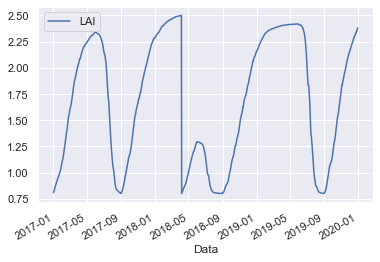

In [8]:
# Finally, we can plot the results to see if the model is working properly
df4.plot(x='Data',y=['LAI'])

<AxesSubplot:xlabel='Data'>

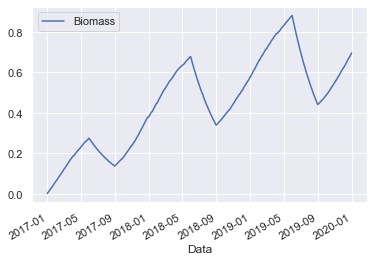

In [59]:
#plotting Biomass - it assumes that organic matter is not removed after harvest
df4.plot(x='Data',y=['Biomass'])